In [1]:
import pandas as pd
import numpy as np

In [2]:
measure_a = pd.read_csv('../data/measurements.csv')

In [3]:
measure_a.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [4]:
measure_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


Este dataframe consta de un total de 388 entradas y 12 features diferentes, de las cuales 4 poseen valores nulos y otras 4 están representadas en formato 'object', cuando todo apunta a que deberían estar representadas en formato 'float'. Mi primer paso será trabajar con estas últimas.

### object columns to float

In [5]:
measure_a.replace(',', '.', regex=True, inplace=True)

In [6]:
measure_a.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,21.5,12,NaN,E10,0,0,0,45,E10
1,12,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [7]:
to_float = ['distance', 'consume', 'temp_inside', 'refill liters']

for feature in to_float:
    measure_a[feature] = pd.to_numeric(measure_a[feature], errors='coerce', downcast='float')

In [8]:
measure_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float32
 1   consume        388 non-null    float32
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float32
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float32
 11  refill gas     13 non-null     object 
dtypes: float32(4), int64(5), object(3)
memory usage: 30.4+ KB


Una vez cada columna está en el formato que le corresponde, paso a analizar aquellas columnas con valores nulos, para ver si hay alguna forma de completar esos datos perdidos.

### temp_inside

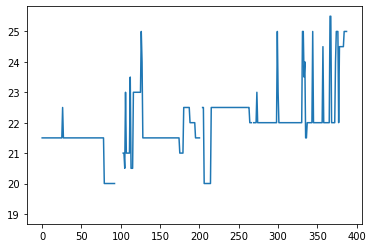

In [9]:
measure_a.temp_inside.plot();

In [10]:
measure_a.temp_inside.describe()

count    376.000000
mean      21.929522
std        1.010455
min       19.000000
25%       21.500000
50%       22.000000
75%       22.500000
max       25.500000
Name: temp_inside, dtype: float64

Por lo que la visualización y los datos muestran, la temperatura en el interior del coche parece no variar significativamente a lo largo del tiempo, por lo que los cambios de estaciones no afectan a esta (posiblemente el coche sea aparcado en un garaje mientras no es usado). 

La temperatura mínima registrada es de 19 grados, mientras que la máxima son 25.5, lo que supone una diferencia de menos de 6 grados. Los datos poseen una desviación de poco más de 1.

Dicho esto, considero razonable sustituir los datos nulos por la temperatura media del coche en el periodo en que se registraron estos datos.

In [11]:
mean_temp = measure_a.temp_inside.describe()['mean']

measure_a.temp_inside.fillna(mean_temp, inplace=True)

In [12]:
measure_a.temp_inside.isna().sum()

0

### specials

Esta columna contiene algunos datos del clima durante los trayectos (si llovía, hacía sol o nevaba; también si el aire acondicionado estaba encendido). 

Por lo que he podido averiguar, los datos comenzaron a ser recopilados en noviembre, el dueño del coche repostaba gasolina SP98 durante el invierno, y al llegar la primavera cambiaba a SP95 E10 (imagino que lo mantenía durante verano y otoño); y al parecer (por la ubicación del usuario que ha subido el dataset) los datos fueron tomados en Hamburgo, aunque esto no es seguro 100%.

A falta de datos como la fecha o ubicación exactas, no podría completar los datos que faltan en esta columna con información fiable. 

In [13]:
measure_a.specials.value_counts(dropna=False)

NaN                   295
rain                   32
sun                    27
AC rain                 9
ac                      8
AC                      6
sun ac                  3
snow                    3
ac rain                 1
AC Sun                  1
half rain half sun      1
AC snow                 1
AC sun                  1
Name: specials, dtype: int64

De todas formas, por los distintos valores que toma, parece que esta columna está relacionada con las columns 'AC', 'rain' y 'sun'. Dichas columnas parecen algo así como el resultado de un .get_dummies de la columna 'specials', aunque esta operación podría ser más precisa si las distintas situaciones estuviesen mejor agrupadas (por ejemplo, hay un tipo 'AC sun', otro 'AC Sun' y otro 'sun ac'.

Como la columna AC ya diferencia aquellos trayecots en los que el aire acondicionado funciono, voy a pasar todos los caracteres a lowercase y eliminar los 'ac' de la columna especials, de esta forma deberían quedar sólo tres tipos distintos: sun, rain, snow.

Por otro lado, voy a sustituir los valores nulos por 'no_special', dando por hecho que durante aquel trayecto no hubo nada reseñable.

In [14]:
measure_a.specials = measure_a.specials.str.lower()
measure_a.specials.replace(['ac ', ' ac'], '', regex=True, inplace=True)

measure_a.specials.fillna('no_special', inplace=True)

measure_a.specials.value_counts(dropna=False)

no_special            295
rain                   42
sun                    32
ac                     14
snow                    4
half rain half sun      1
Name: specials, dtype: int64

Como puede comprobarse, hay todavía 14 valores para 'ac'. Como estos están ya recogidos en la columna 'AC', los asignaré al tipo 'no_special'.

Otro tipo que habría que modificar es el de 'half rain half sun'. En este caso, al haber lluvia, lo pasaré directamente a 'rain'.

In [15]:
to_replace = {'ac': 'no_special', 'half rain half sun': 'rain'}

for old, new in to_replace.items():
    measure_a.specials.replace(old, new, regex=True, inplace=True)
    
measure_a.specials.value_counts(dropna=False)

no_special    309
rain           43
sun            32
snow            4
Name: specials, dtype: int64

De 13 valores, algunos repetidos pero con distinta nomenclatura, la columna 'specials' ha pasado a tener solo 4, sin repetirse ninguno. 

Tras este trabajo, tendría sentido obviar las columns 'rain' y 'sun', y hacer un nuevo .get_dummies() a 'specials', con la información más unificada.

In [16]:
measure_a.drop(['rain', 'sun'], axis=1, inplace=True)
measure_a = pd.concat([measure_a, pd.get_dummies(measure_a.specials)], axis=1) 
measure_a.drop(['specials'], axis=1, inplace=True)
measure_a.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,refill liters,refill gas,no_special,rain,snow,sun
0,28.0,5.0,26,21.5,12,E10,0,45.0,E10,1,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,NaN,NaN,1,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,NaN,NaN,1,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,NaN,NaN,1,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,NaN,NaN,1,0,0,0


### refill liters & refill gas

Realmente, los valores nulos de estas columnas no pueden completarse con mucha información, ya que solamente tienen datos aquellas filas en las que el conductor repostó, y evidentemente no iba a repostar en cada trayecto.

Sin embargo sí se pueden extraer otros datos gracias a estas:

 - Precio de cada repostaje: conociendo los precios de cada tipo de gasolina.

In [17]:
measure_a['refill_spent'] = measure_a['refill liters'] * measure_a['refill gas'].replace({'E10': 1.38, 'SP98': 1.46})

## Nuevos datos
### gas_type a dummies

También se puede convertir la columna 'gas_type' a dummies, ya que tan solo consta de dos valores distintos.

In [18]:
measure_a = pd.concat([measure_a, pd.get_dummies(measure_a.gas_type, prefix='gas', drop_first=True)], axis=1)
measure_a.drop(['gas_type'], axis=1, inplace=True)

In [19]:
measure_a.head()

,distance,consume,speed,temp_inside,temp_outside,AC,refill liters,refill gas,no_special,rain,snow,sun,refill_spent,gas_SP98
0,28.0,5.0,26,21.5,12,0,45.0,E10,1,0,0,0,62.1,0
1,12.0,4.2,30,21.5,13,0,NaN,NaN,1,0,0,0,NaN,0
2,11.2,5.5,38,21.5,15,0,NaN,NaN,1,0,0,0,NaN,0
3,12.9,3.9,36,21.5,14,0,NaN,NaN,1,0,0,0,NaN,0
4,18.5,4.5,46,21.5,15,0,NaN,NaN,1,0,0,0,NaN,0


### Precio de cada trayecto

Es lógico añadir también una columna con el precio de la gasolina por cada uno de los trayectos, algo que será bastante útil a la hora de reflejar los datos.

In [31]:
sp95_price = 1.38
sp98_price = 1.46

measure_a['trip_price'] = measure_a.consume * measure_a.gas_SP98.apply(lambda x: sp95_price if x == 0 else sp98_price)

In [32]:
measure_a

,distance,consume,speed,temp_inside,temp_outside,AC,refill liters,refill gas,no_special,rain,snow,sun,refill_spent,gas_SP98,trip_price
0,28.0,5.0,26,21.5,12,0,45.0,E10,1,0,0,0,62.1,0,6.900
1,12.0,4.2,30,21.5,13,0,NaN,NaN,1,0,0,0,NaN,0,5.796
2,11.2,5.5,38,21.5,15,0,NaN,NaN,1,0,0,0,NaN,0,7.590
3,12.9,3.9,36,21.5,14,0,NaN,NaN,1,0,0,0,NaN,0,5.382
4,18.5,4.5,46,21.5,15,0,NaN,NaN,1,0,0,0,NaN,0,6.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,0,NaN,NaN,1,0,0,0,NaN,1,5.402
384,16.1,4.3,38,25.0,31,1,NaN,NaN,1,0,0,0,NaN,1,6.278
385,16.0,3.8,45,25.0,19,0,NaN,NaN,1,0,0,0,NaN,1,5.548
386,15.4,4.6,42,25.0,31,1,NaN,NaN,1,0,0,0,NaN,1,6.716


## Ordenar datos y crear nuevo csv

Una vez obtenido un dataset limpio, me gustaría ordenar las columnas y guardarlo en csv, para así poder trabajar con él en un nuevo notebook.

In [33]:
cols_sorted = ['distance', 'consume', 'speed', 'gas_SP98', 'temp_inside', 'temp_outside', 'AC', 'no_special', 'rain', 
 'snow', 'sun', 'refill liters', 'refill gas', 'refill_spent', 'trip_price']

measure_a = measure_a.reindex(cols_sorted, axis=1)

In [34]:
measure_a.head()

,distance,consume,speed,gas_SP98,temp_inside,temp_outside,AC,no_special,rain,snow,sun,refill liters,refill gas,refill_spent,trip_price
0,28.0,5.0,26,0,21.5,12,0,1,0,0,0,45.0,E10,62.1,6.900
1,12.0,4.2,30,0,21.5,13,0,1,0,0,0,NaN,NaN,NaN,5.796
2,11.2,5.5,38,0,21.5,15,0,1,0,0,0,NaN,NaN,NaN,7.590
3,12.9,3.9,36,0,21.5,14,0,1,0,0,0,NaN,NaN,NaN,5.382
4,18.5,4.5,46,0,21.5,15,0,1,0,0,0,NaN,NaN,NaN,6.210


In [35]:
measure_a.to_csv('../data/measurements_clean.csv', index=False)